In [15]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [24]:
# copied 5 util files under /content/ and then rename as envs_, seed_, buffers_, torch_, common_

In [43]:
import gym
import numpy as np
import envs_, seed_, buffers_, torch_, common_
import torch
import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Deep Q Learning
# Slide 14
# cs.uwaterloo.ca/~ppoupart/teaching/cs885-spring20/slides/cs885-lecture4b.pdf

# Constants
SEEDS = [1,2,3,4,5]
t = torch_.TorchHelper()
DEVICE = t.device
OBS_N = 4               # State space size
ACT_N = 2               # Action space size
MINIBATCH_SIZE = 10     # How many examples to sample per train step
GAMMA = 0.99            # Discount factor in episodic reward objective
LEARNING_RATE = 5e-4    # Learning rate for Adam optimizer
TRAIN_AFTER_EPISODES = 10   # Just collect episodes for these many episodes
TRAIN_EPOCHS = 5        # Train for these many epochs every time
BUFSIZE = 10000         # Replay buffer size
EPISODES = 300          # Total number of episodes to learn over
TEST_EPISODES = 1       # Test episodes after every train episode
HIDDEN = 512            # Hidden nodes
TARGET_UPDATE_FREQ = 10 # Target network update frequency
STARTING_EPSILON = 1.0  # Starting epsilon
STEPS_MAX = 10000       # Gradually reduce epsilon over these many steps
EPSILON_END = 0.01      # At the end, keep epsilon at this value

# Global variables
EPSILON = STARTING_EPSILON
Q = None

# Create environment
# Create replay buffer
# Create network for Q(s, a)
# Create target network
# Create optimizer
def create_everything(seed):

    seed_.seed(seed)
    env = gym.make("CartPole-v0")
    env.seed(seed)
    test_env = gym.make("CartPole-v0")
    test_env.seed(10+seed)
    buf = buffers_.ReplayBuffer(BUFSIZE)
    Q = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)
    Qt = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)
    OPT = torch.optim.Adam(Q.parameters(), lr = LEARNING_RATE)
    return env, test_env, buf, Q, Qt, OPT

# Update a target network using a source network
def update(target, source):
    for tp, p in zip(target.parameters(), source.parameters()):
        tp.data.copy_(p.data)

# Create epsilon-greedy policy
def policy(env, obs):

    global EPSILON, Q

    obs = t.f(obs).view(-1, OBS_N)  # Convert to torch tensor
    
    # With probability EPSILON, choose a random action
    # Rest of the time, choose argmax_a Q(s, a) 
    if np.random.rand() < EPSILON:
        action = np.random.randint(ACT_N)
    else:
        qvalues = Q(obs)
        action = torch.argmax(qvalues).item()
    
    # Epsilon update rule: Keep reducing a small amount over
    # STEPS_MAX number of steps, and at the end, fix to EPSILON_END
    EPSILON = max(EPSILON_END, EPSILON - (1.0 / STEPS_MAX))
    # print(EPSILON)

    return action


# Update networks
def update_networks(epi, buf, Q, Qt, OPT):
    
    # Sample a minibatch (s, a, r, s', d)
    # Each variable is a vector of corresponding values
    S, A, R, S2, D = buf.sample(MINIBATCH_SIZE, t)
    
    # Get Q(s, a) for every (s, a) in the minibatch
    qvalues = Q(S).gather(1, A.view(-1, 1)).squeeze()

    # Get max_a' Qt(s', a') for every (s') in the minibatch
    q2values = torch.max(Qt(S2), dim = 1).values

    # If done, 
    #   y = r(s, a) + GAMMA * max_a' Q(s', a') * (0)
    # If not done,
    #   y = r(s, a) + GAMMA * max_a' Q(s', a') * (1)       
    targets = R + GAMMA * q2values * (1-D)

    # Detach y since it is the target. Target values should
    # be kept fixed.
    loss = torch.nn.MSELoss()(targets.detach(), qvalues)

    # Backpropagation
    OPT.zero_grad()
    loss.backward()
    OPT.step()

    # Update target network every few steps
    if epi % TARGET_UPDATE_FREQ == 0:
        update(Qt, Q)

    return loss.item()

def tune_update_period(period):
  global TRAIN_AFTER_EPISODES
  TRAIN_AFTER_EPISODES = period


# Play episodes
# Training function
def train(seed):

    global EPSILON, Q
    print("Seed=%d" % seed)

    # Create environment, buffer, Q, Q target, optimizer
    env, test_env, buf, Q, Qt, OPT = create_everything(seed)

    # epsilon greedy exploration
    EPSILON = STARTING_EPSILON

    testRs = []
    last25testRs = []
    print("Training:")
    pbar = tqdm.trange(EPISODES)
    for epi in pbar:

        # Play an episode and log episodic reward
        S, A, R = envs_.play_episode_rb(env, policy, buf)
        
        # Train after collecting sufficient experience
        if epi >= TRAIN_AFTER_EPISODES:

            # Train for TRAIN_EPOCHS
            for tri in range(TRAIN_EPOCHS): 
                update_networks(epi, buf, Q, Qt, OPT)

        # Evaluate for TEST_EPISODES number of episodes
        Rews = []
        for epj in range(TEST_EPISODES):
            S, A, R = envs_.play_episode(test_env, policy, render = False)
            Rews += [sum(R)]
        testRs += [sum(Rews)/TEST_EPISODES]

        # Update progress bar
        last25testRs += [sum(testRs[-25:])/len(testRs[-25:])]
        pbar.set_description("R25(%g)" % (last25testRs[-1]))

    # Close progress bar, environment
    pbar.close()
    print("Training finished!")
    env.close()

    return last25testRs

# Plot mean curve and (mean-std, mean+std) curve with some transparency
# Clip the curves to be between 0, 200
def plot_arrays(vars, color, label):
    mean = np.mean(vars, axis=0)
    std = np.std(vars, axis=0)
    plt.plot(range(len(mean)), mean, color=color, label=label)
    plt.fill_between(range(len(mean)), np.maximum(mean-std, 0), np.minimum(mean+std,200), color=color, alpha=0.3)


def plot_multiple_arrays(listofvars, colors, labels):
    for vars, color, label in zip(listofvars, colors, labels):
      mean = np.mean(vars, axis=0)
      std = np.std(vars, axis=0)
      plt.plot(range(len(mean)), mean, color=color, label=label)
      plt.fill_between(range(len(mean)), np.maximum(mean-std, 0), np.minimum(mean+std,200), color=color, alpha=0.3)
    
    plt.legend(loc = 'upper left')

if __name__ == "__main__":

    #for Problem1
    # Train for different seeds
    curves = []
    for seed in SEEDS:
      for period in [1,10,50,100]:
        tune_update_period(period)
        curves += [train(seed)]

    # Plot the curve for the given seeds
    # plot_arrays(curves, 'b', 'dqn')
    # plt.legend(loc='best')
    # plt.show()
    NUM_PERIODS = 4
    vars = [curves[0::NUM_PERIODS], curves[1::NUM_PERIODS],  curves[2::NUM_PERIODS],  curves[3::NUM_PERIODS]]
    plot_multiple_arrays(vars, ['b', 'g', 'r', 'm'], ['dqn_up1', 'dqn_up10', 'dqn_up50',  'dqn_up100'])

Seed=1
Training:


R25(181.44): 100%|██████████| 300/300 [00:36<00:00,  8.15it/s]


Training finished!
Seed=1
Training:


R25(163.76): 100%|██████████| 300/300 [00:34<00:00,  8.77it/s]


Training finished!
Seed=1
Training:


R25(185): 100%|██████████| 300/300 [00:26<00:00, 11.35it/s]


Training finished!
Seed=1
Training:


R25(153.6): 100%|██████████| 300/300 [00:13<00:00, 21.64it/s]


Training finished!
Seed=2
Training:


R25(148.16): 100%|██████████| 300/300 [00:25<00:00, 11.71it/s]


Training finished!
Seed=2
Training:


R25(153.12): 100%|██████████| 300/300 [00:24<00:00, 12.24it/s]


Training finished!
Seed=2
Training:


R25(125.28): 100%|██████████| 300/300 [00:23<00:00, 12.68it/s]


Training finished!
Seed=2
Training:


R25(152): 100%|██████████| 300/300 [00:15<00:00, 19.50it/s]


Training finished!
Seed=3
Training:


R25(168.96): 100%|██████████| 300/300 [00:28<00:00, 10.46it/s]


Training finished!
Seed=3
Training:


R25(177.44): 100%|██████████| 300/300 [00:27<00:00, 10.99it/s]


Training finished!
Seed=3
Training:


R25(103.96): 100%|██████████| 300/300 [00:18<00:00, 16.45it/s]


Training finished!
Seed=3
Training:


R25(148.08): 100%|██████████| 300/300 [00:15<00:00, 19.59it/s]


Training finished!
Seed=4
Training:


R25(118.16): 100%|██████████| 300/300 [00:29<00:00, 10.17it/s]


Training finished!
Seed=4
Training:


R25(178.04): 100%|██████████| 300/300 [00:27<00:00, 11.02it/s]


Training finished!
Seed=4
Training:


R25(174.08): 100%|██████████| 300/300 [00:19<00:00, 15.59it/s]


Training finished!
Seed=4
Training:


R25(128.16): 100%|██████████| 300/300 [00:14<00:00, 21.33it/s]


Training finished!
Seed=5
Training:


R25(149.84): 100%|██████████| 300/300 [00:26<00:00, 11.36it/s]


Training finished!
Seed=5
Training:


R25(169.6): 100%|██████████| 300/300 [00:27<00:00, 10.77it/s]


Training finished!
Seed=5
Training:


R25(149.96): 100%|██████████| 300/300 [00:18<00:00, 16.53it/s]


Training finished!
Seed=5
Training:


R25(170.32): 100%|██████████| 300/300 [00:14<00:00, 20.62it/s]

Training finished!


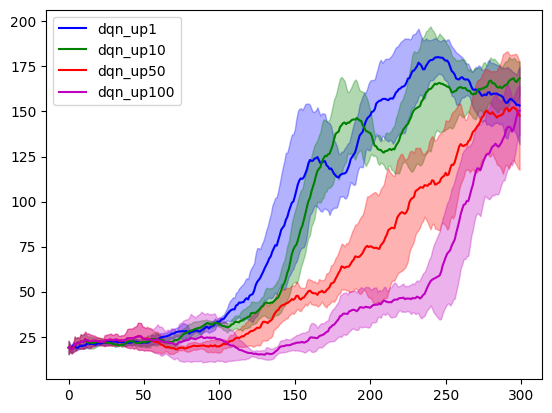

In [45]:
NUM_PERIODS = 4
vars = [curves[0::NUM_PERIODS], curves[1::NUM_PERIODS],  curves[2::NUM_PERIODS],  curves[3::NUM_PERIODS]]
plot_multiple_arrays(vars, ['b', 'g', 'r', 'm'], ['dqn_up1', 'dqn_up10', 'dqn_up50',  'dqn_up100'])